In [41]:
LEAGUE_IDS = {
    2024: "1064047033306136576",
    2025: "1180226065723957248"
}

In [42]:
import requests
import pandas as pd

def get_owner_pick_counts(league_id, year):
    """
    Returns a DataFrame with counts of picks per round (1-4) for each owner at end of season,
    including roster_id and owner_name for readability.
    Ensures owners with no picks are included with 0 counts.
    """
    # 1️⃣ Get rosters for the league
    rosters_url = f"https://api.sleeper.app/v1/league/{league_id}/rosters"
    rosters_resp = requests.get(rosters_url)
    rosters_data = rosters_resp.json()
    
    roster_owner_map = {}
    for roster in rosters_data:
        owner_id = roster['owner_id'] if 'owner_id' in roster else (roster['co_owners'][0] if roster.get('co_owners') else None)
        roster_owner_map[roster['roster_id']] = owner_id

    # 2️⃣ Get drafts
    drafts_url = f"https://api.sleeper.app/v1/league/{league_id}/drafts"
    drafts_resp = requests.get(drafts_url)
    drafts_data = drafts_resp.json()
    draft_id = drafts_data[-1]['draft_id']  # use last draft for the season

    # 3️⃣ Get draft picks
    draft_picks_url = f"https://api.sleeper.app/v1/draft/{draft_id}/picks"
    picks_resp = requests.get(draft_picks_url)
    picks_data = picks_resp.json()
    
    # 4️⃣ Aggregate picks by roster_id and round
    picks_list = []
    for pick in picks_data:
        roster_id = pick['roster_id']
        owner_id = roster_owner_map.get(roster_id, None)
        if owner_id is not None:
            picks_list.append({
                'roster_id': roster_id,
                'owner_id': owner_id,
                'round': pick['round']
            })
    
    picks_df = pd.DataFrame(picks_list)
    
    # Ensure all owners exist, even if they have 0 picks
    all_owners = pd.DataFrame({
        'roster_id': list(roster_owner_map.keys()),
        'owner_id': list(roster_owner_map.values())
    })
    
    # Count picks per round per owner
    pick_counts = picks_df.groupby(['roster_id','owner_id','round']).size().unstack(fill_value=0)
    
    # Make sure rounds 1–4 exist
    for r in range(1,5):
        if r not in pick_counts.columns:
            pick_counts[r] = 0
    
    pick_counts = pick_counts[[1,2,3,4]].reset_index()
    
    # Merge with all owners to include owners with 0 picks
    pick_counts = pd.merge(all_owners, pick_counts, on=['roster_id','owner_id'], how='left')
    pick_counts.fillna(0, inplace=True)  # owners with no picks get 0
    pick_counts[[1,2,3,4]] = pick_counts[[1,2,3,4]].astype(int)
    
    # Add year column
    pick_counts['year'] = year
    
    # Rename columns for clarity
    pick_counts.rename(columns={1:'rd_1', 2:'rd_2', 3:'rd_3', 4:'rd_4'}, inplace=True)
    
    # Map roster_id to owner_name
    ROSTER_TO_OWNER = {
        1: "Jose",
        2: "Daryl",
        3: "Gio",
        4: "Brigido",
        5: "Luis",
        6: "Lalo",
        7: "Devonte",
        8: "Marvin",
        9: "Jacky",
        10: "Bryan"
    }
    pick_counts['owner_name'] = pick_counts['roster_id'].map(ROSTER_TO_OWNER)
    
    # Drop owner_id (Sleeper user ID) if not needed
    pick_counts = pick_counts.drop(columns=['owner_id'])
    
    return pick_counts

all_pick_counts = pd.concat(
    [get_owner_pick_counts(league_id, year) for year, league_id in LEAGUE_IDS.items()],
    ignore_index=True
)

all_pick_counts[['owner_name','year','rd_1','rd_2','rd_3','rd_4']]


,owner_name,year,rd_1,rd_2,rd_3,rd_4
0,Jose,2024,3,4,2,0
1,Daryl,2024,0,0,0,2
2,Gio,2024,1,1,2,2
3,Brigido,2024,0,0,0,2
4,Luis,2024,0,1,1,0
5,Lalo,2024,4,1,1,1
6,Devonte,2024,0,2,1,0
7,Marvin,2024,1,0,2,1
8,Jacky,2024,0,0,0,0
9,Bryan,2024,1,1,1,2


In [43]:
all_pick_counts = all_pick_counts[['owner_name', 'year', 'rd_1', 'rd_2', 'rd_3', 'rd_4']]

In [54]:
import pandas as pd

# Example manual 2026 picks (replace with actual info)
pick_counts_2026 = pd.DataFrame([
    {'owner_name': 'Jose', 'year': 2026, 'rd_1': 2, 'rd_2': 1, 'rd_3': 3, 'rd_4': 3},
    {'owner_name': 'Daryl', 'year': 2026, 'rd_1': 0, 'rd_2': 0, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Gio', 'year': 2026, 'rd_1': 0, 'rd_2': 3, 'rd_3': 1, 'rd_4': 3},
    {'owner_name': 'Brigido', 'year': 2026, 'rd_1': 0, 'rd_2': 0, 'rd_3': 1, 'rd_4': 0},
    {'owner_name': 'Luis', 'year': 2026, 'rd_1': 1, 'rd_2': 1, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Lalo', 'year': 2026, 'rd_1': 3, 'rd_2': 2, 'rd_3': 3, 'rd_4': 0},
    {'owner_name': 'Devonte', 'year': 2026, 'rd_1': 0, 'rd_2': 0, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Marvin', 'year': 2026, 'rd_1': 2, 'rd_2': 1, 'rd_3': 2, 'rd_4': 2},
    {'owner_name': 'Jacky', 'year': 2026, 'rd_1': 0, 'rd_2': 0, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Bryan', 'year': 2026, 'rd_1': 2, 'rd_2': 2, 'rd_3': 0, 'rd_4': 2}
])

pick_counts_2027 = pd.DataFrame([
    {'owner_name': 'Jose', 'year': 2027, 'rd_1': 3, 'rd_2': 1, 'rd_3': 1, 'rd_4': 2},
    {'owner_name': 'Daryl', 'year': 2027, 'rd_1': 0, 'rd_2': 0, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Gio', 'year': 2027, 'rd_1': 1, 'rd_2': 2, 'rd_3': 2, 'rd_4': 2},
    {'owner_name': 'Brigido', 'year': 2027, 'rd_1': 0, 'rd_2': 0, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Luis', 'year': 2027, 'rd_1': 0, 'rd_2': 1, 'rd_3': 0, 'rd_4': 0},
    {'owner_name': 'Lalo', 'year': 2027, 'rd_1': 2, 'rd_2': 1, 'rd_3': 2, 'rd_4': 1},
    {'owner_name': 'Devonte', 'year': 2027, 'rd_1': 0, 'rd_2': 0, 'rd_3': 0, 'rd_4': 2},
    {'owner_name': 'Marvin', 'year': 2027, 'rd_1': 1, 'rd_2': 1, 'rd_3': 1, 'rd_4': 1},
    {'owner_name': 'Jacky', 'year': 2027, 'rd_1': 1, 'rd_2': 0, 'rd_3': 0, 'rd_4': 1},
    {'owner_name': 'Bryan', 'year': 2027, 'rd_1': 2, 'rd_2': 4, 'rd_3': 4, 'rd_4': 1}
])

# Concatenate with existing data
all_pick_counts = pd.concat([all_pick_counts, pick_counts_2026, pick_counts_2027], ignore_index=True)

# Preview
all_pick_counts[['owner_name','year','rd_1','rd_2','rd_3','rd_4']]


,owner_name,year,rd_1,rd_2,rd_3,rd_4
0,Jose,2024,3,4,2,0
1,Lalo,2024,4,1,1,1
2,Gio,2024,1,1,2,2
3,Bryan,2024,1,1,1,2
4,Marvin,2024,1,0,2,1
5,Devonte,2024,0,2,1,0
6,Luis,2024,0,1,1,0
7,Daryl,2024,0,0,0,2
8,Brigido,2024,0,0,0,2
9,Jacky,2024,0,0,0,0


In [60]:
# Save to Parquet
import pyarrow
all_pick_counts.to_parquet("all_pick_counts.parquet", index=False)

In [56]:
weights = {
    'rd_1': 1.0,   # highest value
    'rd_2': 0.7,
    'rd_3': 0.3,
    'rd_4': 0.1    # basically a dart throw
}


In [57]:
# Calculate weighted pick score
all_pick_counts['pick_score'] = (
    all_pick_counts['rd_1'] * weights['rd_1'] +
    all_pick_counts['rd_2'] * weights['rd_2'] +
    all_pick_counts['rd_3'] * weights['rd_3'] +
    all_pick_counts['rd_4'] * weights['rd_4']
)

# Optional: normalize within each season to 0-1
all_pick_counts['pick_score_norm'] = all_pick_counts.groupby('year')['pick_score'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Sort for readability
all_pick_counts = all_pick_counts.sort_values(['year', 'pick_score_norm'], ascending=[True, False])

all_pick_counts = all_pick_counts[['owner_name','year','rd_1','rd_2','rd_3','rd_4','pick_score','pick_score_norm']]



In [59]:
all_pick_counts[all_pick_counts['year'] == 2027]

,owner_name,year,rd_1,rd_2,rd_3,rd_4,pick_score,pick_score_norm
49,Bryan,2027,2,4,4,1,6.1,1.000000
40,Jose,2027,3,1,1,2,4.2,0.688525
45,Lalo,2027,2,1,2,1,3.4,0.557377
42,Gio,2027,1,2,2,2,3.2,0.524590
47,Marvin,2027,1,1,1,1,2.1,0.344262
48,Jacky,2027,1,0,0,1,1.1,0.180328
44,Luis,2027,0,1,0,0,0.7,0.114754
46,Devonte,2027,0,0,0,2,0.2,0.032787
41,Daryl,2027,0,0,0,0,0.0,0.000000
43,Brigido,2027,0,0,0,0,0.0,0.000000


/var/folders/yw/4djwspfd71dd2kz47p89ghvm0000gn/T/ipykernel_2476/1114818385.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pick_score_norm', y='owner_name', data=df_2025, palette='viridis')


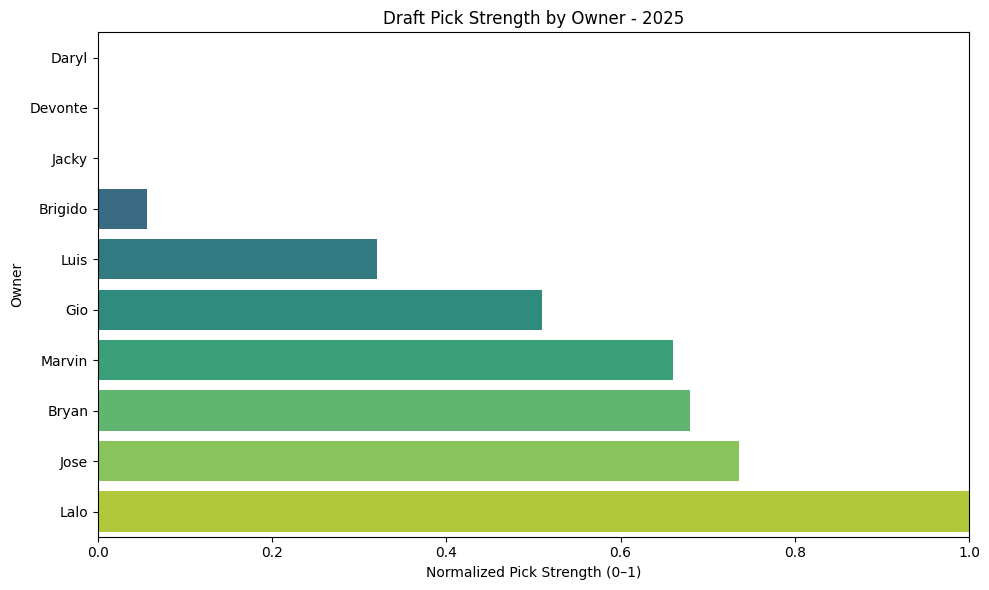

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for 2025
df_2025 = all_pick_counts[all_pick_counts['year'] == 2026]

# Sort by normalized pick score
df_2025 = df_2025.sort_values('pick_score_norm', ascending=True)

plt.figure(figsize=(10,6))
sns.barplot(x='pick_score_norm', y='owner_name', data=df_2025, palette='viridis')

plt.xlabel('Normalized Pick Strength (0–1)')
plt.ylabel('Owner')
plt.title('Draft Pick Strength by Owner - 2025')
plt.xlim(0,1)
plt.tight_layout()
plt.show()


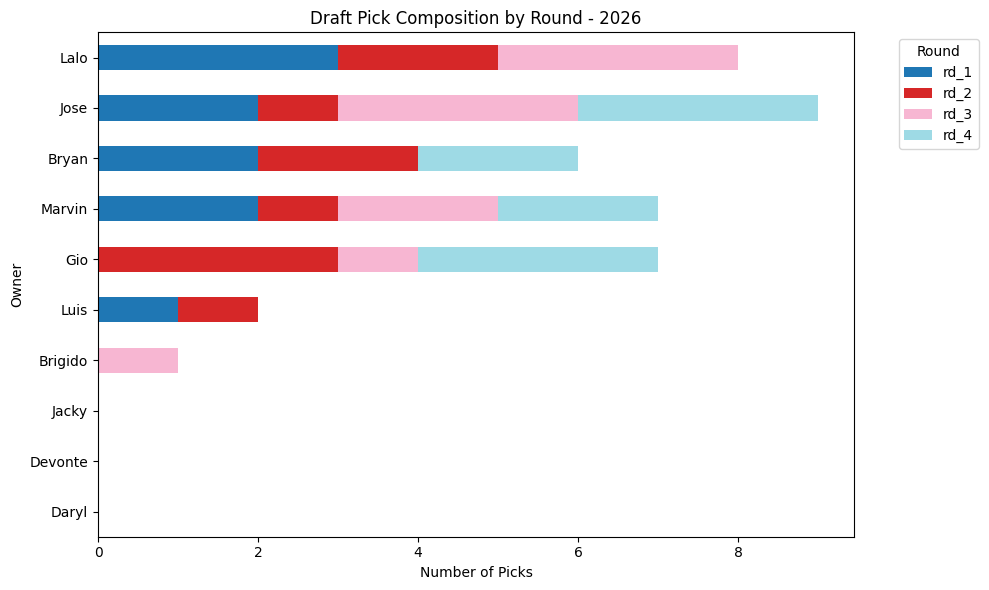

In [52]:
# Only 2025
df_2025_rounds = df_2025[['owner_name','rd_1','rd_2','rd_3','rd_4']].set_index('owner_name')

df_2025_rounds.plot(kind='barh', stacked=True, figsize=(10,6), colormap='tab20')

plt.xlabel('Number of Picks')
plt.ylabel('Owner')
plt.title('Draft Pick Composition by Round - 2026')
plt.legend(title='Round', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


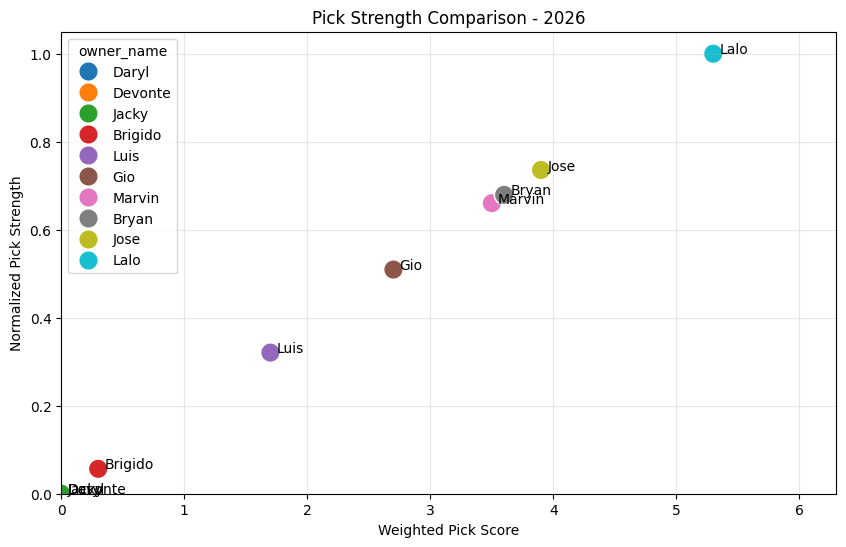

In [53]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='pick_score', y='pick_score_norm', hue='owner_name', data=df_2025, s=200)

for i, row in df_2025.iterrows():
    plt.text(row['pick_score']+0.05, row['pick_score_norm'], row['owner_name'])

plt.xlabel('Weighted Pick Score')
plt.ylabel('Normalized Pick Strength')
plt.title('Pick Strength Comparison - 2026')
plt.xlim(0, df_2025['pick_score'].max()+1)
plt.ylim(0,1.05)
plt.grid(alpha=0.3)
plt.show()
